In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from neuromaps.datasets import fetch_fslr
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

from heteromodes import EigenSolver
from heteromodes.eigentools import calc_eigenreconstruction, calc_eigenreconstruction_topN
from heteromodes.utils import load_hmap

In [2]:
def generate_shades(base_color, n, vmin=0.2, vmax=0.8):
    cmap = plt.get_cmap(base_color, 100)
    return [mcolors.to_hex(cmap(vmin + (vmax - vmin) * i / (n - 1))) for i in range(n)]

In [3]:
n_modes = 100
n_jobs = 10
topN = True

In [4]:
# Load surface and medial wall mask
fslr = fetch_fslr("32k")
surf = fslr["midthickness"][0]
medmask = nib.load(fslr["medial"][0]).darrays[0].data.astype(bool)

with h5py.File(f"{PROJ_DIR}/data/empirical/S255_tfMRI_ALLTASKS_raw_lh.mat", "r") as f:
    key_contrasts = ["social_tom_random", "motor_cue_avg", "gambling_punish_reward",
                        "wm_2bk_0bk", "language_math_story", "emotion_faces_shapes",
                        "relational_match_rel"]

    tfmri_all = np.empty((np.sum(medmask), 255, len(key_contrasts)))
    for i, task_name in enumerate(key_contrasts):
        tfmri_all[:, :, i] = f["zstat"][task_name][:, medmask].T

In [5]:
def recon_task(bold_task, emodes, mass, metric="pearsonr", topN=False):
    # remove nan maps
    bold_task = bold_task[:, ~np.isnan(bold_task).any(axis=0)]

    if not topN:
        _, _, recon_acc = calc_eigenreconstruction(
            bold_task, 
            emodes,
            method="orthogonal",
            mass=mass,
            data_type="maps",
            metric=metric,
        )
        return recon_acc
    
    else:
        _, _, recon_acc, top_mode_ids = calc_eigenreconstruction_topN(
            bold_task,
            emodes,
            mass=mass,
            n=20,
        )
        return recon_acc, top_mode_ids

In [6]:
# Calculate homo modes
solver_hom = EigenSolver(surf=surf, medmask=medmask)
_, emodes_hom = solver_hom.solve(n_modes=n_modes, fix_mode1=True)

results_hom = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(recon_task)(
        tfmri_all[:, :, i],
        emodes_hom,
        solver_hom.mass,
        topN=topN
    ) for i in range(tfmri_all.shape[2])
)

if topN is True:
    acc_hom, top_modes_hom = zip(*results_hom)
else:
    acc_hom = results_hom

acc_mean_hom = [np.mean(acc_hom[i], axis=1) for i in range(tfmri_all.shape[2])]
acc_std_hom = [np.std(acc_hom[i], axis=1) for i in range(tfmri_all.shape[2])]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   13.3s
[Parallel(n_jobs=10)]: Done   2 out of   7 | elapsed:   14.1s remaining:   35.1s
[Parallel(n_jobs=10)]: Done   3 out of   7 | elapsed:   14.4s remaining:   19.2s
[Parallel(n_jobs=10)]: Done   4 out of   7 | elapsed:   14.5s remaining:   10.9s
[Parallel(n_jobs=10)]: Done   5 out of   7 | elapsed:   14.6s remaining:    5.9s
[Parallel(n_jobs=10)]: Done   7 out of   7 | elapsed:   14.7s finished


In [11]:
hmap_label = "myelinmap"
alpha = 1
scaling = "sigmoid"
q_norm = "normal"

# Load hmap
if hmap_label is None:
    hmap = None
    alpha = 0
else:
    hmap = load_hmap(hmap_label=hmap_label, trg_den="32k")
    if alpha == 0:
        raise ValueError("alpha must be non-zero when hmap_label is provided.")
    else:
        alpha = alpha

In [12]:
# Calculate hetero modes
solver_het = EigenSolver(surf=surf, hetero=hmap, medmask=medmask, alpha=alpha, scaling=scaling,
                        q_norm=q_norm)
_, emodes_het = solver_het.solve(n_modes=n_modes, fix_mode1=True)

results_het = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(recon_task)(
        tfmri_all[:, :, i],
        emodes_het,
        solver_het.mass,
        topN=topN
    ) for i in range(tfmri_all.shape[2])
)

if topN is True:
    acc_het, top_modes_het = zip(*results_het)
else:
    acc_het = results_het

acc_mean_het = [np.mean(acc_het[i], axis=1) for i in range(tfmri_all.shape[2])]
acc_std_het = [np.std(acc_het[i], axis=1) for i in range(tfmri_all.shape[2])]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done   2 out of   7 | elapsed:   11.4s remaining:   28.5s
[Parallel(n_jobs=10)]: Done   3 out of   7 | elapsed:   11.6s remaining:   15.4s
[Parallel(n_jobs=10)]: Done   4 out of   7 | elapsed:   11.7s remaining:    8.8s
[Parallel(n_jobs=10)]: Done   5 out of   7 | elapsed:   11.8s remaining:    4.7s
[Parallel(n_jobs=10)]: Done   7 out of   7 | elapsed:   11.8s finished


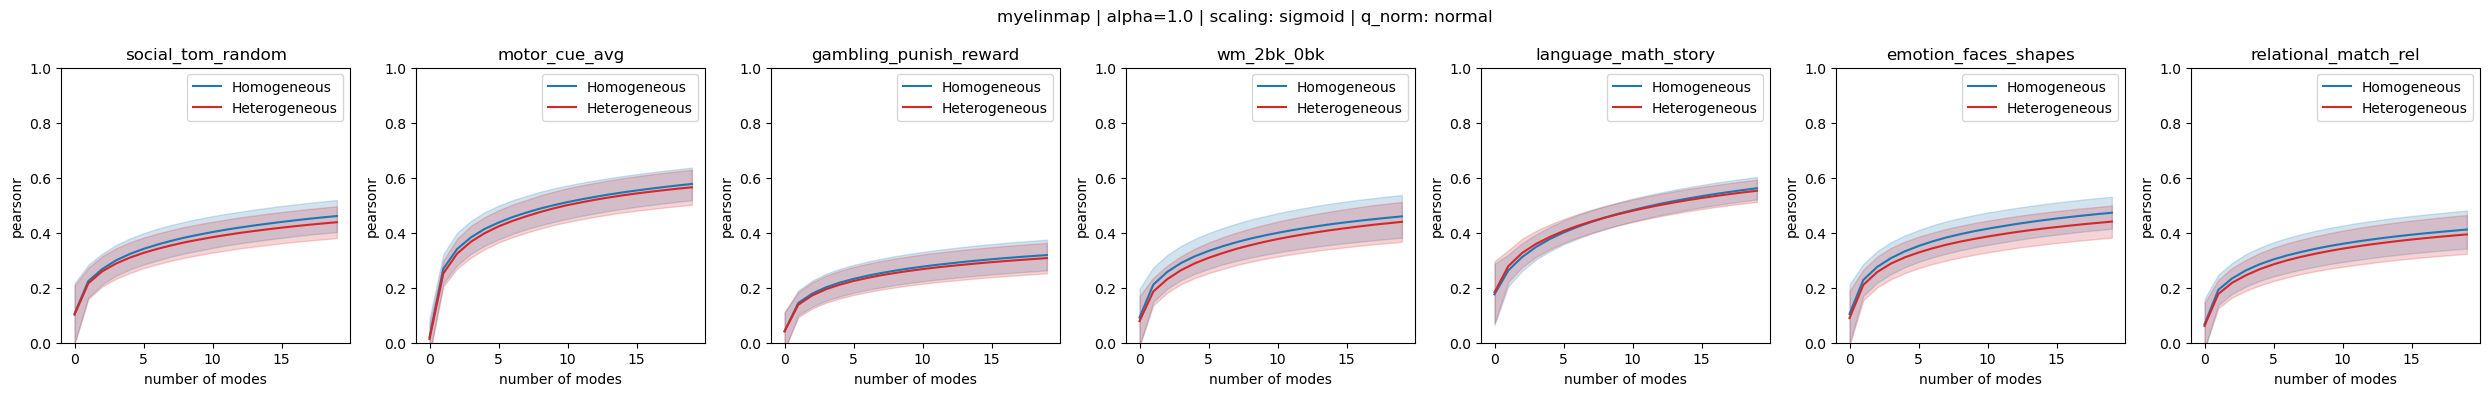

In [13]:
fig, axs = plt.subplots(1, 7, figsize=(25, 4))
axs = axs.ravel()

for i, task in enumerate(key_contrasts):
    axs[i].plot(acc_mean_hom[i], label=f"Homogeneous", color="tab:blue")
    axs[i].plot(acc_mean_het[i], label=f"Heterogeneous", color="tab:red")

    # Plot standard deviation
    axs[i].fill_between(range(len(acc_std_hom[i])), acc_mean_hom[i] - acc_std_hom[i], acc_mean_hom[i] + acc_std_hom[i], color="tab:blue", alpha=0.2)
    axs[i].fill_between(range(len(acc_std_het[i])), acc_mean_het[i] - acc_std_het[i], acc_mean_het[i] + acc_std_het[i], color="tab:red", alpha=0.2)

    axs[i].set_title(task)
    axs[i].set_xlabel("number of modes")
    axs[i].set_ylabel("pearsonr")
    # axs[i].set_xticks(range(50, 250, 50))
    # axs[i].set_xlim(0, 200)
    axs[i].set_ylim(0, 1)
    axs[i].legend()

plt.suptitle(f"{hmap_label} | alpha={alpha:.1f} | scaling: {scaling} | q_norm: {q_norm}")
# axs[-1].axis("off")
plt.tight_layout()

plt.show()

In [14]:
task_id = 2
plt.plot(recon_acc_hom[:, task_id], marker='.', linestyle='-', label="Homogeneous")
plt.plot(recon_acc_het[:, task_id], marker='.', linestyle='-', label="Heterogeneous")
plt.legend()

x = np.arange(20)
for i in range(20):
    plt.text(x[i], recon_acc_hom[i, task_id], top_modes_hom[i, task_id]+1, fontsize=8, ha='right', va='bottom')
    plt.text(x[i], recon_acc_het[i, task_id], top_modes_het[i, task_id]+1, fontsize=8, ha='right', va='bottom')

plt.xticks(x, x+1)
plt.xlabel("Number of top modes")
plt.ylabel("Reconstruction accuracy")
plt.title(f"Task {labels[task_id+1]} | alpha={alpha:.2f}")
plt.show()

NameError: name 'recon_acc_hom' is not defined

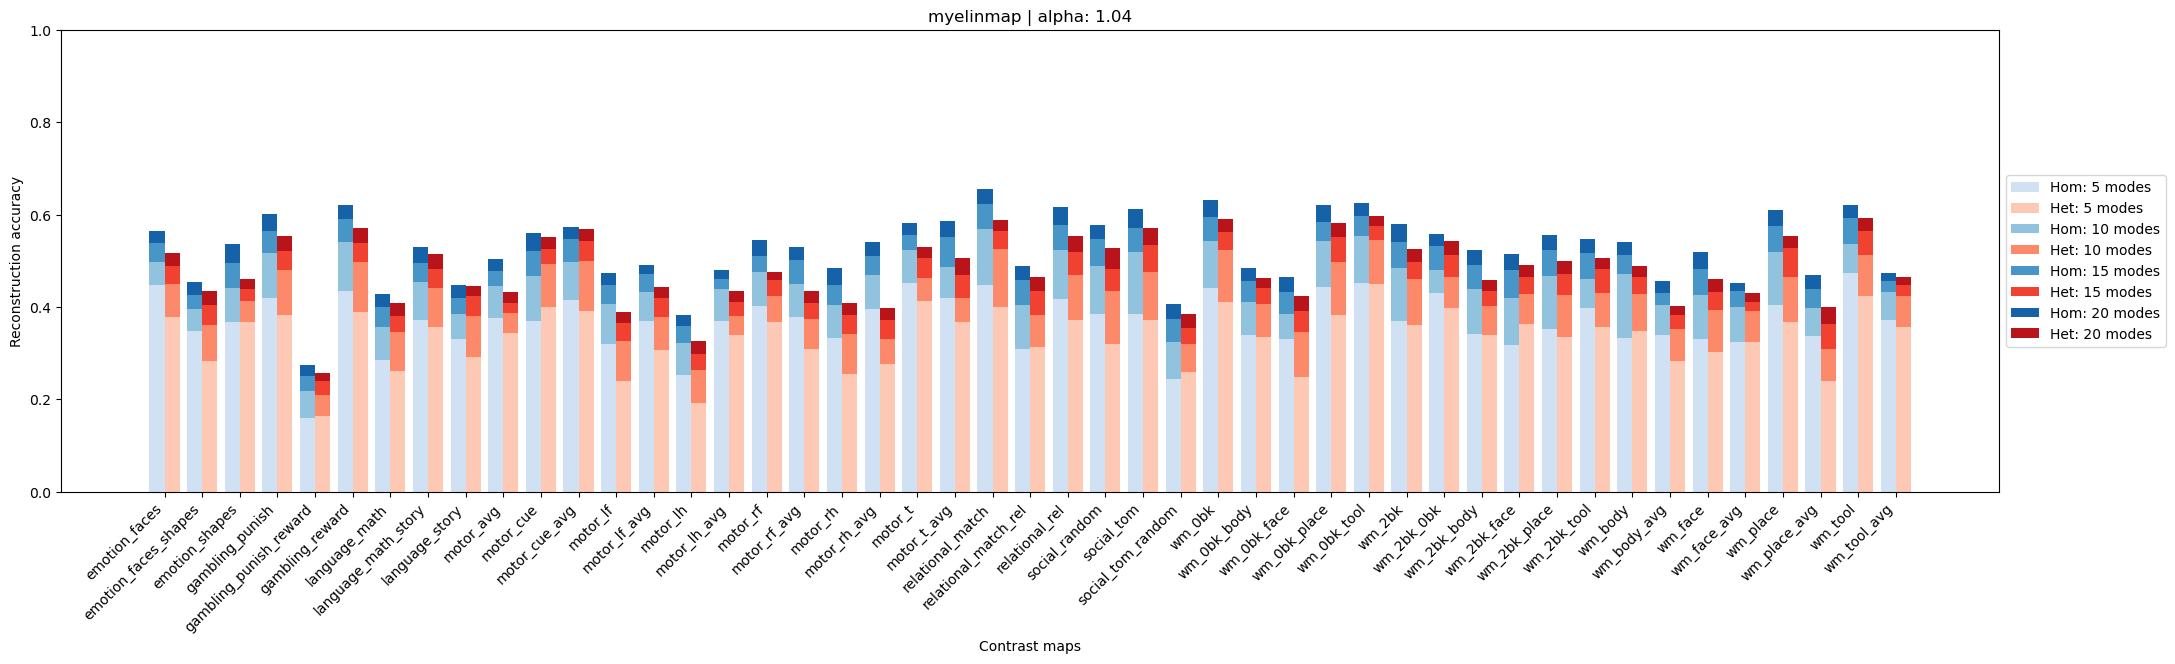

In [ ]:
mode_ids = [4, 9, 14, 19]

# Generate colors dynamically
blues = generate_shades('Blues', len(mode_ids))  # Light to dark blue
reds = generate_shades('Reds', len(mode_ids))  # Light to dark red

fig, ax = plt.subplots(figsize=(25, 6))
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

# Initialize bottom arrays
bottom_hom, bottom_het = 0, 0
# Generate stacked bar plot
for i, mode_id in enumerate(mode_ids):
    ax.bar(x - width/2, hom_recon_acc[mode_id, :] - bottom_hom, width=width, bottom=bottom_hom, label=f'Hom: {mode_id+1} modes', color=blues[i])
    ax.bar(x + width/2, het_recon_acc[mode_id, :] - bottom_het, width=width, bottom=bottom_het, label=f'Het: {mode_id+1} modes', color=reds[i])
    
    # Update bottom values for next iteration
    bottom_hom = hom_recon_acc[mode_id, :]
    bottom_het = het_recon_acc[mode_id, :]

# Labels and title
ax.set_xlabel('Contrast maps')
ax.set_ylabel('Reconstruction accuracy')
ax.set_title(f'{hmap} | alpha: {alpha}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0, 1)

# Move legend outside to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.show()